In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from polimi.systems import vdp, vdp_jac, y0min

In [2]:
def _one_period(fun,t0,y0,T_guess,jac=None,rtol=1e-8,atol=None):
    # find the equation of the plane containing y0 and
    # orthogonal to fun(t0,y0)
    f = fun(t0,y0)
    w = f/np.linalg.norm(f)
    b = -np.dot(w,y0)
    # integrate the system for 2 guesses of the period
    if atol is None:
        atol = 1e-8 + np.zeros(y0.shape)
    sol = solve_ivp(fun,[t0,t0+2*T_guess],y0,method='BDF',
                    jac=jac,atol=atol,rtol=rtol,
                    events=lambda t,y: np.dot(w,y)+b,
                    dense_output=True)
    t_start = None   # the first event is always the inital point
    for t_ev in sol['t_events'][0]:
        if t_start is None:
            t_start = t_ev
            continue
        x_ev = sol['sol'](t_ev)
        f = fun(t_ev,x_ev)
        # check whether the crossing of the plane is in
        # the same direction as the initial point
        if np.dot(w,f/np.linalg.norm(f))+b > 0:
            T = t_ev-t_start
            #print('The period is', T)
            break
    # compute the "vector field" of the envelope
    print('t_start =',t_start)
    G = 1./T * (sol['sol'](t_start+T) - sol['sol'](t_start))
    return (G,T)

Integrating the transient... done.


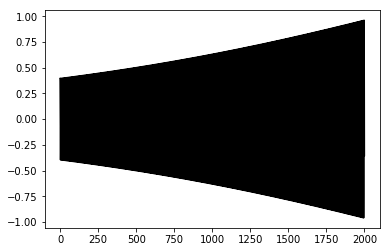

t_start = 2000.0
The period is 6.283184.
G = [-0.00013532 -0.00034409]


In [4]:
A = [0,0]
T = [5,200]
epsilon = 0.001
y0 = np.random.uniform(size=2)
fun = lambda t,y: vdp(t,y,epsilon,A,T)
jac = lambda t,y: vdp_jac(t,y,epsilon)
ttran = 2000
if ttran > 0:
    print('Integrating the transient...',end='')
    tran = solve_ivp(fun,[0,ttran],y0,method='BDF',
                     atol=1e-8+np.zeros(2),
                     rtol=1e-10,jac=jac)
    print(' done.')
    plt.plot(tran['t'],tran['y'][0],'k')
    plt.show()
    y0 = tran['y'][:,-1]
G,period = _one_period(fun, ttran, y0, 1.1*np.min(T), jac)
print('The period is %.6f.' % period)
print('G =', G)

In [ ]:
A = [5,5]
T = [10,100]
epsilon = 0.001
y0 = np.random.uniform(size=2)
with_tran = True
if with_tran:
    print('Integrating transient...')
    tran = solve_ivp(lambda t,y: vdp(t,y,epsilon,A,T),[0,1000],y0,
                     method='BDF',atol=1e-8+np.zeros(2),rtol=1e-8,
                     jac=lambda t,y: vdp_jac(t,y,epsilon))
    plt.plot(tran['t'],tran['y'][0],'k')
    plt.show()
    y0 = tran['y'][:,-1]
#y0 = np.array([0.1,0.1])
f = vdp(0,y0,epsilon,A,T)
y1 = y0 + f
w = f/np.linalg.norm(f)
b = -np.dot(w,y0)
print('y0 =', y0)
print('f =', f)
print('w =', w)
print('norm(w) =', np.linalg.norm(w))
print('b =', b)

In [ ]:
tend = 10*T[0]
sol = solve_ivp(lambda t,y: vdp(t,y,epsilon,A,T),[0,tend],y0,
                method='BDF',atol=1e-8+np.zeros(2),rtol=1e-8,
                jac=lambda t,y: vdp_jac(t,y,epsilon),
                events=lambda t,y: np.dot(w,y)+b, dense_output=True)


pos = []
d = []
for i in range(len(sol['t'])):
    pos.append(np.dot(w,sol['y'][:,i])+b)
    f = vdp(sol['t'][i],sol['y'][:,i],epsilon,A,T)
    d.append(np.dot(w,f/np.linalg.norm(f)))
pos = np.array(pos)
d = np.array(d)
x = np.array([y0[0]-6,y0[0]+6])
y = -(w[0]*x+b)/w[1]

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.plot(sol['t'],sol['y'][0],'k')
#plt.plot(sol['t'],pos,'r')
#plt.plot(sol['t'],d,'b')
for t_ev in sol['t_events'][0]:
    plt.plot(t_ev,sol['sol'](t_ev)[0],'o',color=[0,.9,0])
yl = plt.ylim()

plt.subplot(1,2,2)
plt.plot([y0[0],y1[0]],[y0[1],y1[1]],'r')
plt.plot(x,y,'b')
plt.plot(sol['y'][0],sol['y'][1],'k')
plt.plot(y0[0],y0[1],'go')
for i in range(1,len(sol['t_events'][0])):
    t_ev = sol['t_events'][0][i]
    x_ev = sol['sol'](t_ev)
    f = vdp(t_ev,x_ev,epsilon,A,T)
    if np.dot(w,f/np.linalg.norm(f))+b > 0:
        col = [1,.5,0]
    else:
        col = [1,0,.5]
    plt.plot(x_ev[0],x_ev[1],'o',color=col)
plt.axis('square')

plt.show()

In [ ]:
sol['t_events'][0]

In [ ]:
for i in range(1,len(sol['t_events'][0])):
    t_ev = sol['t_events'][0][i]
    x_ev = sol['sol'](t_ev)
    f = vdp(t_ev,x_ev,epsilon,A,T)
    if np.dot(w,f/np.linalg.norm(f))+b > 0:
        period = t_ev
        print('The period is', period-sol['t_events'][0][0])
        break